# Probando!!!

In [1]:
import medmnist, torch
from medmnist import INFO, Evaluator
import torch.utils.data as data

import os, sys
project_dir = os.path.join(os.getcwd(),'..')
if project_dir not in sys.path:
    sys.path.append(project_dir)


print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v2.2.2 @ https://github.com/MedMNIST/MedMNIST/


In [2]:
data_flag = 'pneumoniamnist'
# data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [228]:
from torchvision import transforms
from torch.utils import data

# function for normalize values to 0 and 1
def normalize(data:torch.Tensor):
    data_min = data.min()
    data_max = data.max()
    data = (data - data_min) / (data_max - data_min)
    return data

# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32,32)),
    transforms.Normalize(mean=[.5], std=[.5])
    # transforms.Normalize(mean=[.16], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

# pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=4*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: /home/abian/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /home/abian/.medmnist/pneumoniamnist.npz


In [229]:
train_dataset_original_labels = train_dataset.labels.copy()

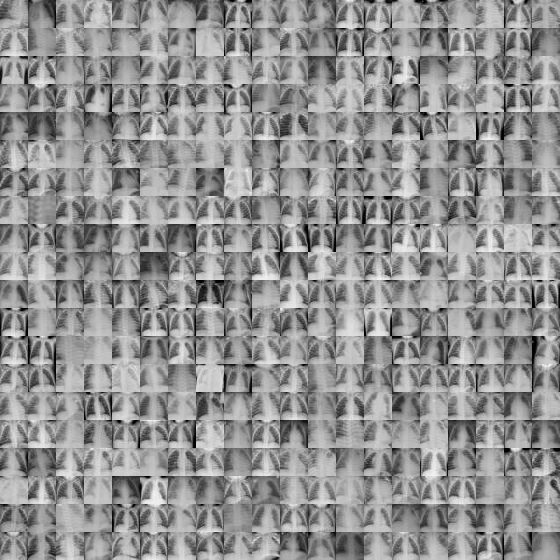

In [230]:
train_dataset.montage(length=20)

In [231]:
# from torch.utils.data import Subset, DataLoader
# import numpy as np

# normal_idx = torch.tensor(np.where((train_dataset_original_labels == 1))[0])
# anomaly_idx = torch.tensor(np.where((train_dataset_original_labels == 0))[0])

# idx = torch.cat([normal_idx, anomaly_idx[:512]])

# # change labels to 0 and 1, the rest to -1
# train_dataset.labels = np.ones_like(train_dataset_original_labels).flatten() * -1
# # Original
# # train_dataset.labels[normal_idx] = 0
# # train_dataset.labels[anomaly_idx] = 1

# #Modified
# train_dataset.labels[normal_idx] = 1
# train_dataset.labels[anomaly_idx] = 0

# x_train_set = Subset(train_dataset, idx)
# train_loader =  DataLoader(x_train_set, 512, shuffle=True)

In [232]:
from torch.utils.data import Subset, DataLoader
import numpy as np

normal_idx = torch.tensor(np.where((train_dataset_original_labels == 1))[0])
anomaly_idx = torch.tensor(np.where((train_dataset_original_labels == 0))[0])

idx = torch.cat([normal_idx, anomaly_idx[:512]])


# change labels to 0 and 1, the rest to -1
train_dataset.labels = np.ones_like(train_dataset_original_labels).flatten() * -1
# Original
train_dataset.labels[normal_idx] = 0
train_dataset.labels[anomaly_idx] = 1

x_train_set = Subset(train_dataset, idx)
train_loader =  DataLoader(x_train_set, 128, shuffle=True)

In [233]:
print(normal_idx.shape, anomaly_idx.shape)

bin_count = np.array([0,0])
for _, y in train_loader:
    bin_count += np.bincount(y.flatten(), minlength=2)

print(bin_count)

torch.Size([3494]) torch.Size([1214])
[3494  512]


# Model

In [234]:
import torch
from torch import nn
from VAE.AnomalyDetector import AnomalyDetector
from VAE.utils import SGVBL, cosine_scheduler

# class VAEModel(nn.Module):
#     def __init__(self, input_size, latent_space):
#         super(VAEModel, self).__init__()
#         conv_out_size = input_size // (2*2)
#         self.encoder = nn.Sequential(
#             nn.Conv2d(1,16, 3, stride=1, padding=1),
#             nn.BatchNorm2d(16),
#             nn.Dropout2d(0.2),
#             nn.ReLU(),
#             nn.MaxPool2d(3, stride=2, padding=1),
#             nn.Conv2d(16, 32, 3, stride=1, padding=1),
#             nn.BatchNorm2d(32),
#             nn.Dropout2d(0.2),
#             nn.ReLU(),
#             nn.MaxPool2d(3, stride=2, padding=1),
#             nn.Flatten(),
#             nn.Linear(32*(conv_out_size**2), 128),
#             nn.BatchNorm1d(128),
#             nn.Dropout(0.5),
#             nn.ReLU(),
#         )

#         self.botleneck = AnomalyDetector(128, latent_space)

#         self.decoder = nn.Sequential(
#             nn.Linear(latent_space, 128),
#             nn.BatchNorm1d(128),
#             # nn.Dropout(0.1),
#             nn.ReLU(),
#             nn.Linear(128, 32*(conv_out_size**2)),
#             nn.BatchNorm1d(32*(conv_out_size**2)),
#             # nn.Dropout(0.1),
#             nn.ReLU(),
#             nn.Unflatten(1, (32, conv_out_size, conv_out_size)),
#             nn.Upsample(scale_factor=2),
#             nn.Conv2d(32, 16, 3, stride=1, padding=1),
#             nn.BatchNorm2d(16),
#             # nn.Dropout2d(0.1),
#             nn.ReLU(),
#             nn.Upsample(scale_factor=2),
#             nn.Conv2d(16, 1, 3, stride=1, padding=1),
#         )


#     def forward(self, x:torch.Tensor) -> torch.Tensor:
#         x = self.encoder(x)
#         x = self.botleneck(x)
#         x = self.decoder(x)
#         return x

# model = VAEModel(28, 2)
# from torch.nn.functional import mse_loss
# sgvbl = SGVBL(model, len(x_train_set), mle=mse_loss)

In [291]:
from ADeLEn.model import ADeLEn
from torch.nn.functional import mse_loss

model = ADeLEn(32, [1, 4, 6, 12], [128, 2], skip_connection=False)
from torch.nn.functional import mse_loss
sgvbl = SGVBL(model, len(x_train_set), mle=mse_loss)

# Training

In [324]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.train()
n_epochs = 100
from tqdm import tqdm
# kl_weight = 0.02

epoch_iterator = tqdm(
        range(n_epochs),
        leave=True,
        unit="epoch",
        postfix={"tls": "%.4f" % -1},
    )

kl_weight = 1.5*cosine_scheduler(n_epochs)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)
for epoch in epoch_iterator:
    epoch_loss = 0.
    # kl_weight = min(kl_weight+0.012, .9)
    for x, y in train_loader:
        # check if there are a target with 1
        # if torch.any(y == 1):
            # print("Anomaly detected")
            # break
        x = x.to(device) # GPU
        opt.zero_grad()
        x_hat = torch.tanh(model(x))
        # loss = sgvbl(x, x_hat, y, kl_weight[epoch])
        loss = sgvbl(x, x_hat, y, 1)
        epoch_loss += loss.detach().item()

        loss.backward()
        opt.step()
    
    epoch_iterator.set_postfix(tls="%.3f" % (epoch_loss/len(train_loader)))

model = model.eval()

100%|██████████| 100/100 [01:48<00:00,  1.08s/epoch, tls=513.902]


# Result

In [293]:
import numpy as np
from matplotlib import pyplot as plt

def plot_latent(model, data, num_batches=100):
    model.eval()
    fig = plt.figure(figsize=(5,5))
    with torch.no_grad():
        for i, (x, y) in enumerate(data):
            x = x.to(device)
            z = model.botleneck(model.encoder(x))
            z = z.cpu().detach().numpy()
            y = y.cpu().detach().numpy()
            anomalies = np.where(y == 1)
            normal = np.where(y == 0)
            if i == 0:
                plt.scatter(z[normal, 0], z[normal, 1], c='r', alpha=.7, label='normal')
                plt.scatter(z[anomalies, 0], z[anomalies, 1], c='b', alpha=.7, label='anomalies')
            else:
                plt.scatter(z[normal, 0], z[normal, 1], c='r',alpha=.7)
                plt.scatter(z[anomalies, 0], z[anomalies, 1], c='b',alpha=.7)
           
            if i > num_batches:
                plt.legend()
                return
    plt.legend()
    return fig

In [294]:
model.eval()
# model.train()
plot_latent(model, train_loader_at_eval, num_batches=1)

AttributeError: 'ADeLEn' object has no attribute 'botleneck'

<Figure size 500x500 with 0 Axes>

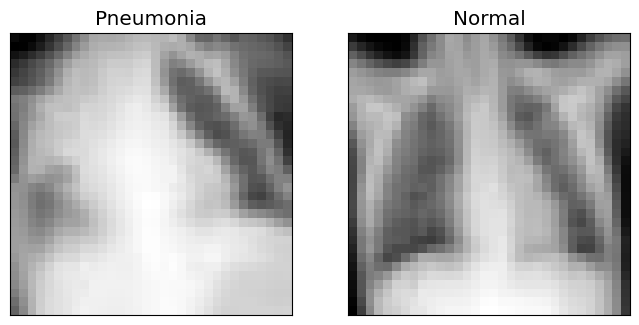

In [326]:
x, y = next(iter(train_loader))
x_0 = x[np.argwhere(y==0)[0].squeeze()[0]].unsqueeze(0)
x_1 = x[np.argwhere(y==1)[0].squeeze()[0]].unsqueeze(0)
x = torch.cat([x_0, x_1], dim=0)
# _ = model.bottleneck(model.encoder(x.to(device)))
_ = model(x.to(device))

mu, sigma = model.bottleneck[1].anomaly_detector.mu.detach().cpu(), model.bottleneck[1].anomaly_detector.sigma.detach().cpu()

plt.figure(figsize=(8,5))
plt.subplot(1,2,1)
plt.title("Pneumonia", fontsize='x-large')
# plt.xlabel("$\mathcal{N}([%.3f, %.3f], [%.3f, %.3f])$" % (*mu[0].numpy().tolist(), *sigma[0].numpy().tolist()), fontsize='large')
plt.xticks([])
plt.yticks([])
plt.imshow(x[0][0], cmap='gray')
plt.subplot(1,2,2)
plt.title("Normal", fontsize='x-large')
# plt.xlabel("$\mathcal{N}([%.3f, %.3f], [%.3f, %.3f])$" % (*mu[1].numpy().tolist(), *sigma[1].numpy().tolist()), fontsize='large')
plt.xticks([])
plt.yticks([])
plt.imshow(x[1][0], cmap='gray')

plt.savefig('figures/medmnist_test.pdf', bbox_inches='tight')
plt.show()

In [327]:
x = torch.cat([x_0, x_1])
# z = model.bottleneck(model.encoder(x.to(device))).detach().cpu()
model.bottleneck[1].anomaly_detector.mu.detach().cpu(), model.bottleneck[1].anomaly_detector.sigma.detach().cpu()

(tensor([[-0.0004, -0.0002],
         [ 0.0019,  0.0039]]),
 tensor([[0.8644, 0.8674],
         [1.9152, 1.9146]]))

(tensor(0.0441, device='cuda:0', grad_fn=<MseLossBackward0>),
 tensor(0.1028, device='cuda:0', grad_fn=<MseLossBackward0>))

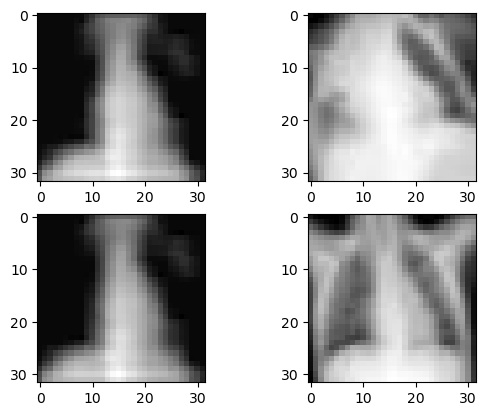

In [345]:
x_hat = model(x_0.to(device))
plt.subplot(2,2,1)
plt.imshow(x_hat[0,0].detach().cpu(), cmap='gray')
plt.subplot(2,2,2)
plt.imshow(x_0[0,0], cmap='gray')

x_hat = model(x_1.to(device))
plt.subplot(2,2,3)
plt.imshow(x_hat[0,0].detach().cpu(), cmap='gray')
plt.subplot(2,2,4)
plt.imshow(x_1[0,0], cmap='gray')

mse_loss(x_hat, x_0.to(device)), mse_loss(x_hat, x_1.to(device))


In [346]:
bottleneck, unflatten = model.bottleneck[1:]
bottleneck = bottleneck.bottleneck[2]

In [347]:
import numpy as np
def plot_reconstructed(autoencoder, r0=(-10, 10), r1=(-10, 10), n=12):
    w = 32
    img = np.zeros((n*w, n*w))

    bottleneck, unflatten = autoencoder.bottleneck[1:]
    bottleneck = bottleneck.bottleneck[2]

    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = torch.tanh(autoencoder.decoder(unflatten(bottleneck(z)))) # ADeLEn
            # x_hat = torch.tanh(autoencoder.decoder(z))
            x_hat = x_hat.reshape(32, 32).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    
    plt.xlabel('$\mathcal{N}(0, \sigma_1)$', fontsize='x-large')
    plt.ylabel('$\mathcal{N}(0, \sigma_2)$', fontsize='x-large')
    plt.imshow(img, extent=[*r0, *r1], cmap='viridis')

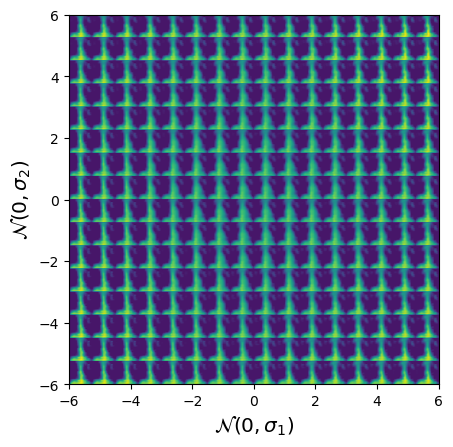

In [349]:
model.eval()
plot_reconstructed(model, r0=(-6, 6), r1=(-6, 6), n=16)

In [350]:
x_test, y_test = next(iter(test_loader))
model.eval()
print(x_test.shape)
x_0 = x_test[np.argwhere(y_test==0)[0].squeeze()[:100]]
x_1 = x_test[np.argwhere(y_test==1)[0].squeeze()[:100]]

x = torch.cat([x_0, x_1], dim=0)

x_enc = model.encoder(x.to(device))
# x_enc, sk = model.encoder(x.to(device))
flatten, bottleneck, unflatten = model.bottleneck[:3]
bottleneck = bottleneck.bottleneck[:2]
x_bottleneck = bottleneck(x_enc.flatten(start_dim=1))

anomaly_detector = bottleneck[1]
sigma = anomaly_detector.sigma.detach().cpu()
sigma.mean(axis=0), sigma.std(axis=0)

torch.Size([512, 1, 32, 32])


(tensor([1.0548, 1.0583]), tensor([0.2774, 0.2775]))

In [351]:
sigma[:100].mean(axis=0), sigma[100:].mean(axis=0)

(tensor([1.2219, 1.2258]), tensor([0.8878, 0.8908]))

In [323]:
sigma[100:]


tensor([[0.6640, 0.6711],
        [0.9455, 0.9510],
        [0.7286, 0.7333],
        [0.6285, 0.6347],
        [0.8331, 0.8355],
        [0.8451, 0.8458],
        [0.6727, 0.6796],
        [0.7195, 0.7244],
        [0.7072, 0.7140],
        [0.8851, 0.8882],
        [0.7133, 0.7175],
        [0.7337, 0.7423],
        [1.0377, 1.0404],
        [0.7492, 0.7540],
        [1.0172, 1.0211],
        [0.8947, 0.8979],
        [0.6579, 0.6648],
        [0.6394, 0.6485],
        [0.9598, 0.9614],
        [0.9625, 0.9645],
        [0.7212, 0.7261],
        [0.7697, 0.7738],
        [0.6222, 0.6308],
        [0.8265, 0.8293],
        [0.6418, 0.6504],
        [0.7222, 0.7267],
        [0.8763, 0.8798],
        [0.6217, 0.6300],
        [0.8908, 0.8925],
        [0.7660, 0.7697],
        [0.7716, 0.7761],
        [0.7073, 0.7141],
        [0.6520, 0.6610],
        [0.7610, 0.7670],
        [0.7259, 0.7303],
        [0.8848, 0.8867],
        [0.9279, 0.9307],
        [0.6202, 0.6294],
        [0.7

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
mu_2d = pca.fit_transform(x_bottleneck.detach().cpu().numpy())

import matplotlib.pyplot as plt

plt.scatter(mu_2d[:, 0], mu_2d[:, 1])
plt.show()

In [ ]:
x_enc.shape